## CFB Data Linear Regression and Outlier Detection

#### Load in modules and packages

In [368]:
import numpy as np
from numpy import meshgrid
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

#### Create DataFrames

In [15]:
all_games_df = pd.DataFrame(data = pd.read_csv('all_games_data.csv', index_col=0))
field_pos_df = pd.DataFrame(data = pd.read_csv('all_games_field_pos_data.csv', index_col=0))
recruit_df = pd.DataFrame(data = pd.read_csv('all_teams_recruit_data.csv', index_col=0))

In [ ]:
print(all_games_df.head())
print(field_pos_df.head())
print(recruit_df.head())

In [22]:
# OK what do I want to start looking at first. I guess first let's see what kind of columns all_games_data has

all_games_df.columns

Index(['home_school', 'home_school_id', 'home_points', 'home_fumblesRecovered',
       'home_rushingTDs', 'home_puntReturnYards', 'home_puntReturnTDs',
       'home_puntReturns', 'home_passingTDs', 'home_kickReturnYards',
       'home_kickReturnTDs', 'home_kickReturns', 'home_kickingPoints',
       'home_firstDowns', 'home_thirdDownEff', 'home_fourthDownEff',
       'home_totalYards', 'home_netPassingYards', 'home_completionAttempts',
       'home_yardsPerPass', 'home_rushingYards', 'home_rushingAttempts',
       'home_yardsPerRushAttempt', 'home_totalPenaltiesYards',
       'home_turnovers', 'home_fumblesLost', 'home_interceptions',
       'home_possessionTime', 'away_school', 'away_school_id', 'away_points',
       'away_fumblesRecovered', 'away_rushingTDs', 'away_passingTDs',
       'away_kickReturnYards', 'away_kickReturnTDs', 'away_kickReturns',
       'away_kickingPoints', 'away_interceptionYards', 'away_interceptionTDs',
       'away_passesIntercepted', 'away_firstDowns', 'away_

In [40]:
all_games_df['home_points'] - all_games_df['away_points']

0       17
1      -38
2       23
3        2
4       20
        ..
8932    12
8933    -3
8934   -26
8935   -14
8936    -6
Length: 8108, dtype: int64

In [44]:
# OK we need a win/loss column.... 


home = all_games_df.home_points

conditions = [all_games_df.home_points > all_games_df.away_points, all_games_df.home_points < all_games_df.away_points]
choice_list_home = [True, False]
choice_list_away = [False, True]


all_games_df['home_win'] = np.select(conditions, choice_list_home)
all_games_df['away_win'] = np.select(conditions, choice_list_away)

In [54]:
all_games_df[['home_points', 'away_points','home_win','away_win']]

,home_points,away_points,home_win,away_win
0,34,17,1,0
1,10,48,0,1
2,30,7,1,0
3,26,24,1,0
4,27,7,1,0
...,...,...,...,...
8932,26,14,1,0
8933,31,34,0,1
8934,23,49,0,1
8935,35,49,0,1


Continuing to adjust the data

I want 1 row per team now so that we can begin to make regressions based on win count per season vs. season stats

In [ ]:
# all_games_df = final_df[all_games_df.year == 2023]
# all_games_df.columns

In [186]:
# The possession time columns are not really in a "usable" state, since they are object columns written as xx:xx
# These steps eventually change the columns to individual numeric columns and finally to one comparable total_sec column
all_games_df['away_possessionTime'] = all_games_df['away_possessionTime'].astype(str)
all_games_df['home_possessionTime'] = all_games_df['home_possessionTime'].astype(str)

all_games_df[['away_possession_minutes', 'away_possession_seconds']] = all_games_df['away_possessionTime'].str.split(':', expand=True)
all_games_df[['home_possession_minutes', 'home_possession_seconds']] = all_games_df['home_possessionTime'].str.split(':', expand=True)


all_games_df['away_possession_minutes'] = all_games_df['away_possession_minutes'].astype(float)
all_games_df['away_possession_seconds'] = all_games_df['away_possession_seconds'].astype(float)
all_games_df['home_possession_minutes'] = all_games_df['home_possession_minutes'].astype(float)
all_games_df['home_possession_seconds'] = all_games_df['home_possession_seconds'].astype(float)

all_games_df['away_poss_total_sec'] = (all_games_df['away_possession_seconds'] + (all_games_df['away_possession_minutes'] * 60.0))
all_games_df['home_poss_total_sec'] = (all_games_df['home_possession_seconds'] + (all_games_df['home_possession_minutes'] * 60.0))

In [187]:
all_games_df.away_poss_total_sec

0       1946.0
1       1817.0
2       1069.0
3       1527.0
4       1334.0
         ...  
8932    1553.0
8933    2228.0
8934    1471.0
8935    1787.0
8936    2008.0
Name: away_poss_total_sec, Length: 8108, dtype: float64

### 1 row per team per game (so game ID is 2 per row)
Will allow us to get yearly averages, per week averages, and regress on wins per year

In [244]:
home_cols = [col for col in all_games_df.columns if 'home_' in col]
#still want game ID, year, and week. Seems useful.
home_cols.extend(['id', 'year', 'week'])

away_cols = [col for col in all_games_df.columns if 'away_' in col]
away_cols.extend(['id', 'year', 'week'])

home_df = all_games_df.loc[:, home_cols]
away_df = all_games_df.loc[:, away_cols]

In [232]:
all_games_df.loc[:, away_cols]

,away_school,away_school_id,away_points,away_fumblesRecovered,away_rushingTDs,away_passingTDs,away_kickReturnYards,away_kickReturnTDs,away_kickReturns,away_kickingPoints,...,away_sacks,away_qbHurries,away_passesDeflected,away_win,away_possession_minutes,away_possession_seconds,away_poss_total_sec,id,year,week
0,Navy,2426,17,0.0,2.0,0.0,64.0,0.0,4.0,5.0,...,NaN,NaN,NaN,0,32.0,26.0,1946.0,400547982,2014,1
1,UAB,5,48,1.0,4.0,2.0,64.0,0.0,2.0,12.0,...,NaN,NaN,NaN,1,30.0,17.0,1817.0,400548010,2014,1
2,UMass,113,7,0.0,0.0,1.0,95.0,0.0,4.0,1.0,...,NaN,NaN,NaN,0,17.0,49.0,1069.0,400547728,2014,1
3,UCF,2116,24,1.0,2.0,1.0,142.0,0.0,5.0,6.0,...,NaN,NaN,NaN,0,25.0,27.0,1527.0,400547642,2014,1
4,Houston,248,7,1.0,1.0,0.0,89.0,0.0,6.0,1.0,...,NaN,NaN,NaN,0,22.0,14.0,1334.0,400547644,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,Tulane,2655,14,1.0,1.0,1.0,87.0,0.0,5.0,2.0,...,1.0,0.0,4.0,0,25.0,53.0,1553.0,401539477,2023,14
8933,Washington,264,34,0.0,2.0,2.0,-1.0,0.0,1.0,10.0,...,0.0,7.0,4.0,1,37.0,8.0,2228.0,401539475,2023,14
8934,Troy,2653,49,2.0,5.0,1.0,10.0,0.0,2.0,7.0,...,5.0,1.0,3.0,1,24.0,31.0,1471.0,401539484,2023,14
8935,Liberty,2335,49,0.0,5.0,2.0,78.0,0.0,4.0,7.0,...,0.0,3.0,7.0,1,29.0,47.0,1787.0,401539476,2023,14


In [233]:
print(home_df.columns)
print(away_df.columns)
print(all_games_df.columns)

Index(['home_school', 'home_school_id', 'home_points', 'home_fumblesRecovered',
       'home_rushingTDs', 'home_puntReturnYards', 'home_puntReturnTDs',
       'home_puntReturns', 'home_passingTDs', 'home_kickReturnYards',
       'home_kickReturnTDs', 'home_kickReturns', 'home_kickingPoints',
       'home_firstDowns', 'home_thirdDownEff', 'home_fourthDownEff',
       'home_totalYards', 'home_netPassingYards', 'home_completionAttempts',
       'home_yardsPerPass', 'home_rushingYards', 'home_rushingAttempts',
       'home_yardsPerRushAttempt', 'home_totalPenaltiesYards',
       'home_turnovers', 'home_fumblesLost', 'home_interceptions',
       'home_possessionTime', 'home_interceptionYards', 'home_interceptionTDs',
       'home_passesIntercepted', 'home_totalFumbles', 'home_tacklesForLoss',
       'home_defensiveTDs', 'home_tackles', 'home_sacks', 'home_qbHurries',
       'home_passesDeflected', 'home_win', 'home_possession_minutes',
       'home_possession_seconds', 'home_poss_total_sec'

Putting the two dfs back together

In [245]:
away_df.columns = away_df.columns.str.removeprefix('away_')
home_df.columns = home_df.columns.str.removeprefix('home_')

frames = [away_df, home_df]

In [246]:
away_df.columns

Index(['school', 'school_id', 'points', 'fumblesRecovered', 'rushingTDs',
       'passingTDs', 'kickReturnYards', 'kickReturnTDs', 'kickReturns',
       'kickingPoints', 'interceptionYards', 'interceptionTDs',
       'passesIntercepted', 'firstDowns', 'thirdDownEff', 'fourthDownEff',
       'totalYards', 'netPassingYards', 'completionAttempts', 'yardsPerPass',
       'rushingYards', 'rushingAttempts', 'yardsPerRushAttempt',
       'totalPenaltiesYards', 'turnovers', 'fumblesLost', 'interceptions',
       'possessionTime', 'puntReturnYards', 'puntReturnTDs', 'puntReturns',
       'totalFumbles', 'tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks',
       'qbHurries', 'passesDeflected', 'win', 'possession_minutes',
       'possession_seconds', 'poss_total_sec', 'id', 'year', 'week'],
      dtype='object')

In [247]:
final_df = pd.concat(frames)

final_df.loc[8933]

,school,school_id,points,fumblesRecovered,rushingTDs,passingTDs,kickReturnYards,kickReturnTDs,kickReturns,kickingPoints,...,sacks,qbHurries,passesDeflected,win,possession_minutes,possession_seconds,poss_total_sec,id,year,week
8933,Washington,264,34,0.0,2.0,2.0,-1.0,0.0,1.0,10.0,...,0.0,7.0,4.0,1,37.0,8.0,2228.0,401539475,2023,14
8933,Oregon,2483,31,0.0,1.0,3.0,NaN,NaN,NaN,7.0,...,2.0,13.0,1.0,0,22.0,52.0,1372.0,401539475,2023,14


#### OK, FINALLY we can throw together some yearly averages per game

### Regression on various yearly averages and win totals

In [265]:
#limiting df results to top 133 ranked schools this year so that the data is better
import requests
response = requests.get(url="https://www.cbssports.com/college-football/rankings/cbs-sports-rankings/")
response.status_code

200

In [282]:
import bs4
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')
table_body = soup.find('table').tbody

#Don't really care about the order, they just need to be in here
top_teams = [span.text for span in table_body.find_all('span',{'class': 'TeamName'})]

In [ ]:
# A decent bit of data is missing from 2014 - 2015 for a lot of these schools... 
# Considering dropping rows that have NaNs....
#ex:
# print(final_df.groupby(['school','year']).mean().loc['Kent State'])
# print(final_df.isna().sum())

# holding off on doing that until I use those columns..

In [341]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16216 entries, 0 to 8936
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               16216 non-null  object 
 1   school_id            16216 non-null  int64  
 2   points               16216 non-null  int64  
 3   fumblesRecovered     16214 non-null  float64
 4   rushingTDs           16213 non-null  float64
 5   passingTDs           16211 non-null  float64
 6   kickReturnYards      14151 non-null  float64
 7   kickReturnTDs        14151 non-null  float64
 8   kickReturns          14151 non-null  float64
 9   kickingPoints        15944 non-null  float64
 10  interceptionYards    9041 non-null   float64
 11  interceptionTDs      9041 non-null   float64
 12  passesIntercepted    9041 non-null   float64
 13  firstDowns           16214 non-null  float64
 14  thirdDownEff         16214 non-null  object 
 15  fourthDownEff        16214 non-null  

In [358]:
# need to adjust some columns and data types so that we can get a mean, since they're objects

final_df['thirdDownEff'] = final_df['thirdDownEff'].astype(str)
final_df['fourthDownEff'] = final_df['fourthDownEff'].astype(str)
final_df['completionAttempts'] = final_df['completionAttempts'].astype(str)
# final_df['totalPenaltiesYards'] = final_df['totalPenaltiesYards'].astype(str)


final_df[['thirdDownConverts','thirdDownAttempts']]= final_df['thirdDownEff'].str.split('-', expand=True)
final_df[['fourthDownConverts', 'fourthDownAttempts']] = final_df['fourthDownEff'].str.split('-', expand=True)
final_df[['completions','passAttempts']] = final_df['completionAttempts'].str.split('-', expand=True)
# final_df[['totalPenalties','penaltyYards']] = final_df['totalPenaltiesYards'].str.split('-', expand=True)


final_df['thirdDownConverts'] = final_df['thirdDownConverts'].astype(float)
final_df['thirdDownAttempts'] = final_df['thirdDownAttempts'].astype(float)
final_df['fourthDownConverts'] = final_df['fourthDownConverts'].astype(float)
final_df['fourthDownAttempts'] = final_df['fourthDownAttempts'].astype(float)
final_df['completions'] = final_df['completions'].astype(float)
final_df['passAttempts'] = final_df['passAttempts'].astype(float)
# final_df['totalPenalties'] = final_df['totalPenalties'].astype(float)
# final_df['penaltyYards'] = final_df['penaltyYards'].astype(float)


# Do I care about getting an average? Idk

final_df['thirdDownEff'] = ((final_df['thirdDownConverts']) / (final_df['thirdDownAttempts']))

In [359]:
mean_df = final_df.groupby(['school','year']).mean()
# Kind of want to be able to leverage Tableau, so I'm exporting the average file
mean_df.to_csv('all_teams_year_avg.csv')

<Figure size 1200x1000 with 0 Axes>

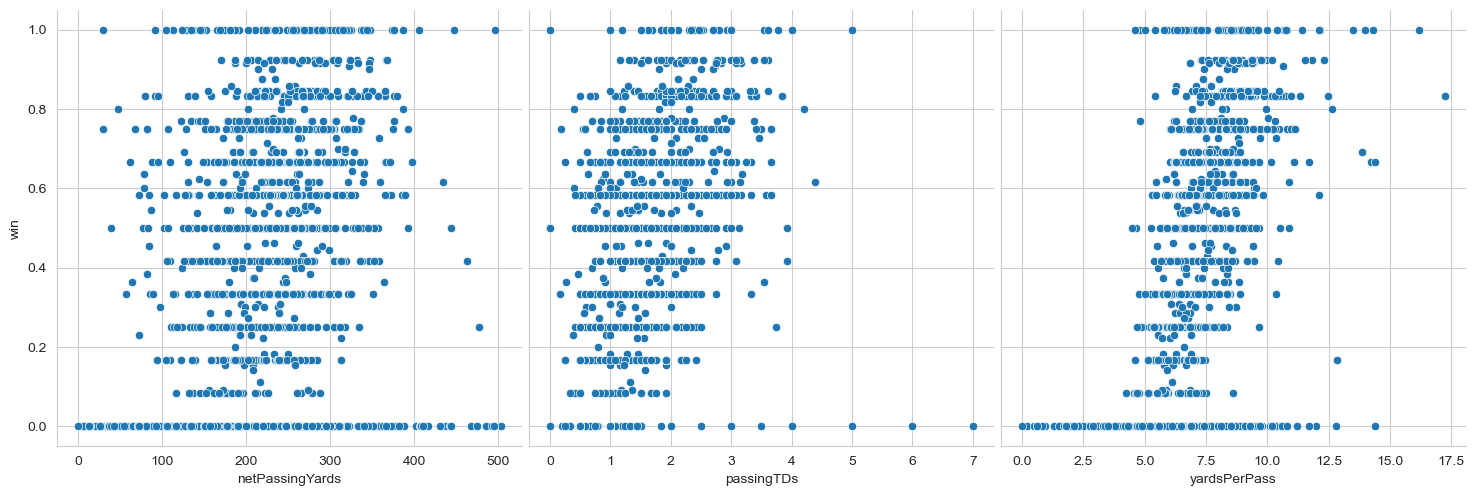

In [360]:
mean_df.dropna()

plt.figure(figsize=(12,10))


sns.pairplot(mean_df
             ,y_vars= ['win']
             ,x_vars=['netPassingYards','passingTDs','yardsPerPass']
            ,height = 5
)

plt.show()

In [362]:
# a lot of 0 or 1 values in the win column above. Investigating

mean_df.loc[mean_df['win'] == 0]
mean_df.loc[mean_df['win'] == 1]

# dropping those and trying again

mean_df = mean_df.drop(mean_df[mean_df['win'] == 1].index)
mean_df = mean_df.drop(mean_df[mean_df['win'] == 0].index)

In [363]:
mean_df.columns

Index(['school_id', 'points', 'fumblesRecovered', 'rushingTDs', 'passingTDs',
       'kickReturnYards', 'kickReturnTDs', 'kickReturns', 'kickingPoints',
       'interceptionYards', 'interceptionTDs', 'passesIntercepted',
       'firstDowns', 'thirdDownEff', 'totalYards', 'netPassingYards',
       'yardsPerPass', 'rushingYards', 'rushingAttempts',
       'yardsPerRushAttempt', 'turnovers', 'fumblesLost', 'interceptions',
       'puntReturnYards', 'puntReturnTDs', 'puntReturns', 'totalFumbles',
       'tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries',
       'passesDeflected', 'win', 'possession_minutes', 'possession_seconds',
       'poss_total_sec', 'id', 'week', 'thirdDownConverts',
       'thirdDownAttempts', 'fourthDownConverts', 'fourthDownAttempts',
       'completions', 'passAttempts'],
      dtype='object')

<Figure size 1000x700 with 0 Axes>

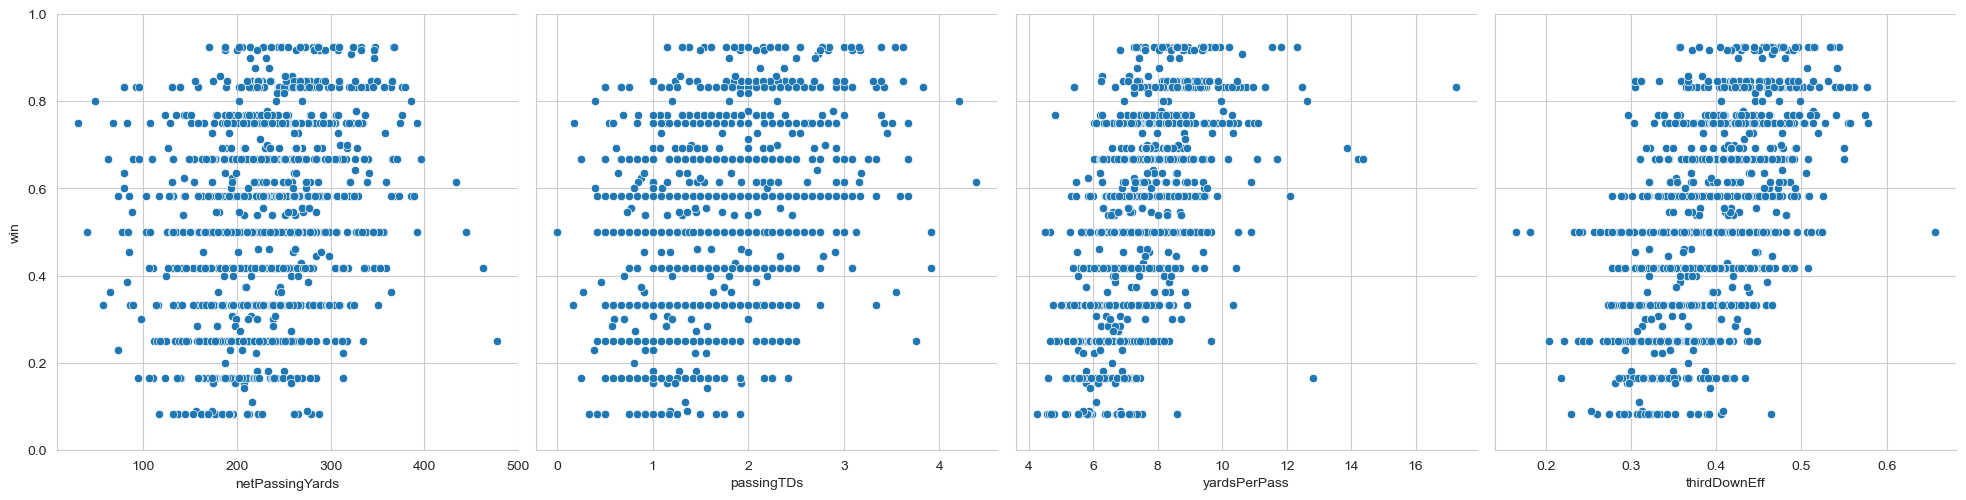

In [364]:
plt.figure(figsize=(10,7))


sns.pairplot(mean_df
             ,y_vars= ['win']
             ,x_vars=['netPassingYards','passingTDs','yardsPerPass', 'thirdDownEff']
            ,height = 5
)
plt.ylim(bottom = 0, top = 1)
plt.show()

In [369]:
# train_test split
fb_train, fb_test = train_test_split(mean_df.copy(),
                                        random_state = 445,
                                        shuffle = True,
                                        test_size=.2)



In [367]:
# kfold obect k = 5
kfold = KFold(5,
                 shuffle = True,
                 random_state = 470)

In [375]:
## make an array of zeros that will hold our mses
mses = np.zeros((3, 5))

## This keeps track of what split we are on
i = 0
## fill in what is missing in the for loop declaration
for train_index, test_index in kfold.split(fb_train):
    ## now we get the training splits and the holdout split
    ### Training
    fb_t_t = fb_train.iloc[train_index]
    
    ### Holdout set
    fb_ho = fb_train.iloc[test_index]
    
    
    ### This is Model 0 ###
    ## take the mean W from the training set
    ## we need predictions for the entire holdout set
    pred0 = fb_t_t.win.mean() * np.ones(len(fb_ho))
    
    ### This is Model 1 ###
    ## W = beta_0 + beta_1 * R + epsilon
    ## Define the LinearRegression object
    model1 = LinearRegression(copy_X = True)
    
    ## fit model1 on the training data, fb_t_t
    ## don't forget you may need to reshape the data
    model1.fit(fb_t_t.yardsPerPass.values.reshape(-1,1),
                  fb_t_t.win.values)
    
    ## get the prediction on holdout set
    pred1 = model1.predict(fb_ho.yardsPerPass.values.reshape(-1,1))
    
    ### This is Model 2 ###
    ## W = beta_0 + beta_1 * RA + epsilon
    ## Define the LinearRegression object
    model2 = LinearRegression(copy_X=True)
    
    ## fit model1 on the training data, fb_t_t
    ## don't forget you may need to reshape the data
    model2.fit(fb_t_t.netPassingYards.values.reshape(-1,1), fb_t_t.win.values)
    
    ## get the prediction on holdout set
    pred2 = model2.predict(fb_ho.netPassingYards.values.reshape(-1,1))
    
    
    ### Recording the MSES ###
    ## mean_squared_error takes in the true values, then the predicted values
    ## model 0
    mses[0,i] = mean_squared_error(fb_ho.win.values, pred0)
    
    ## model 1
    mses[1,i] = mean_squared_error(fb_ho.win.values, pred1)
    
    ## model 2
    mses[2,i] = mean_squared_error(fb_ho.win.values, pred2)
    
    ## increase i by 1
    i = i + 1

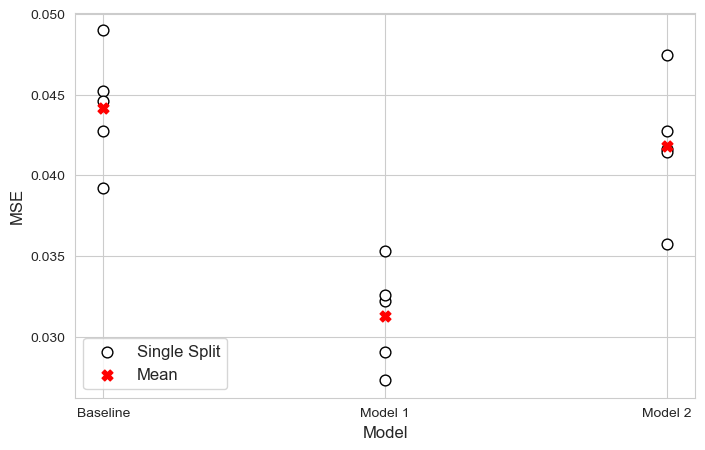

In [376]:
## This figure will compare the performance
plt.figure(figsize=(8,5))

plt.scatter(np.zeros(5), 
            mses[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")
plt.scatter(np.ones(5), 
            mses[1,:], 
            s=60, 
            c='white',
            edgecolor='black')
plt.scatter(2*np.ones(5), 
            mses[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

plt.scatter([0,1,2], 
            np.mean(mses, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

plt.legend(fontsize=12)

plt.xticks([0,1,2],["Baseline", "Model 1", "Model 2"], fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Model", fontsize=12)
plt.ylabel("MSE", fontsize=12)

plt.show()

### Multiple Linear Regression

In [377]:
# Training setup
X_train = np.ones((len(fb_train), 3))

X_train[:,1:] = fb_train[['yardsPerPass', 'netPassingYards']].values
y_train = fb_train.win.values


## Calculate the normal equation
beta_hat = np.linalg.inv(X_train.transpose().dot(X_train)).dot(X_train.transpose()).dot(y_train)

# looking at beta_hat
print("beta_0_hat =", beta_hat[0])
print("beta_1_hat =", beta_hat[1])
print("beta_2_hat =", beta_hat[2])

beta_0_hat = -0.1880220464590254
beta_1_hat = 0.0895310763699576
beta_2_hat = 0.0001428085344357157


In [378]:
y_pred_numpy = beta_hat[0] + beta_hat[1] * X_train[:,1] + beta_hat[2] * X_train[:,2]

print("the training mse is", np.sum(np.power(y_train-y_pred_numpy, 2))/len(y_train))

the training mse is 0.031172644515300517


In [380]:
## Make the model object
reg = LinearRegression(copy_X=True, fit_intercept=False)

## Fit the model object
## note I do NOT have to use reshape here
## because X_train is a 2D np.array
reg.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [381]:
## look at coef
reg.coef_

array([-1.88022046e-01,  8.95310764e-02,  1.42808534e-04])

In [382]:
## Make a prediction
y_pred_sklearn = reg.predict(X_train)

In [398]:
## calculate the mse
print("the mse is", np.sum(np.power(y_train-y_pred_sklearn, 2))/len(y_train))

the mse is 0.031172644515300517


In [392]:
from mpl_toolkits.mplot3d import Axes3D


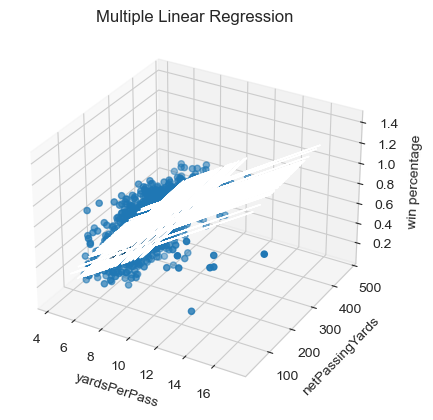

In [397]:

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the independent variables
x = mean_df['yardsPerPass']
y = mean_df['netPassingYards']
z = mean_df['win']

# Add the data points
ax.scatter(x, y, z)

# Fit a plane using np.linalg.lstsq
A = np.vstack([x, y, np.ones_like(x)]).T
plane_coef, _, _, _ = np.linalg.lstsq(A, z, rcond=None)

# Create a meshgrid for the plane
x_plane, y_plane = np.meshgrid(x, y)
z_plane = plane_coef[0] * x_plane + plane_coef[1] * y_plane + plane_coef[2]

# Add the regression plane
ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.5)

# Add labels and title
ax.set_xlabel('yardsPerPass')
ax.set_ylabel('netPassingYards')
ax.set_zlabel('win percentage')
plt.title('Multiple Linear Regression')

# Show the plot
plt.show()

<Figure size 1200x1000 with 0 Axes>

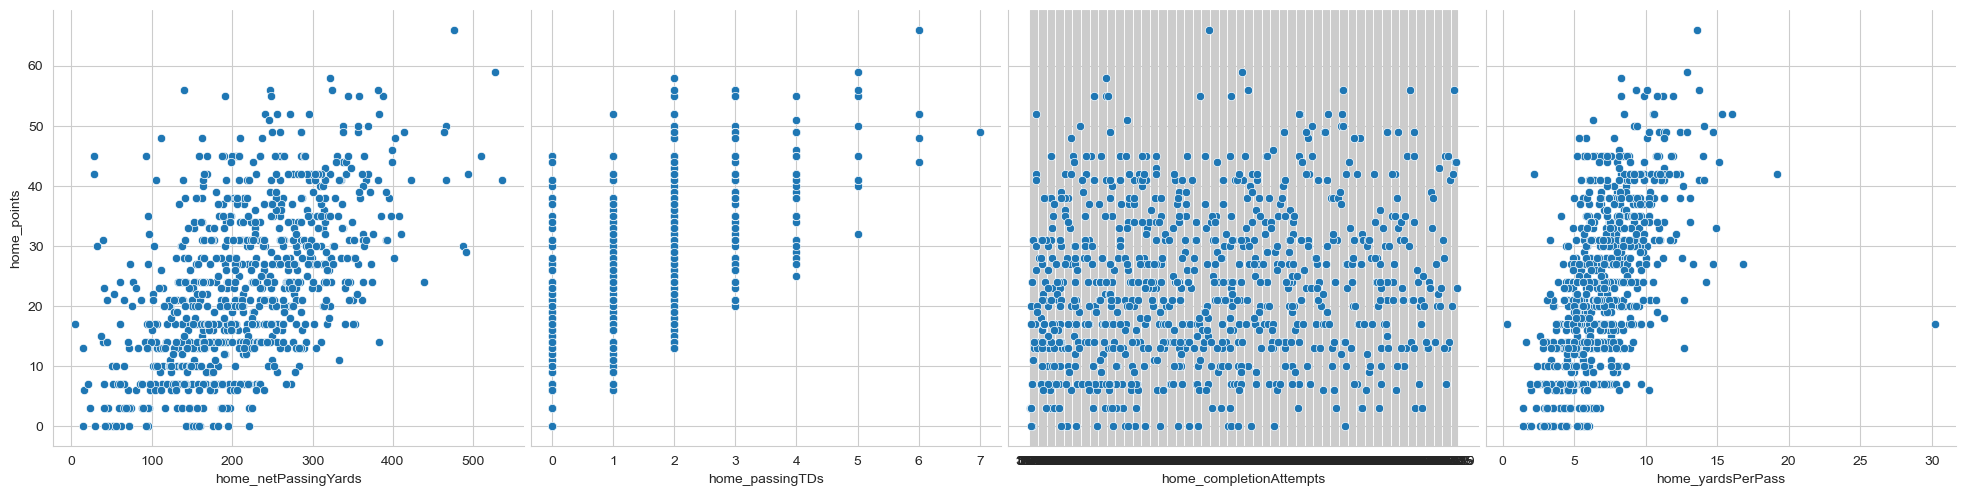

In [171]:

# dot = np.where(all_games_df.home_win == 1, 'b','r')

plt.figure(figsize=(12,10))


sns.pairplot(all_games_df
             ,y_vars= ['home_points']
             ,x_vars=['home_netPassingYards','home_passingTDs','home_completionAttempts','home_yardsPerPass']
            ,height = 5
)
    # all_games_df.home_poss_total_sec, all_games_df.home_win, 60)


# (all_games_df.home_netPassingYards, all_games_df.home_win, c=dot, s=12)

# plt.plot(line,'k', linewidth = 2)

# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)

# plt.ylabel("Home Win (Y/N)", fontsize=12)
# plt.xlabel("Home Possesion Seconds", fontsize=12)

plt.title("", fontsize=14)

plt.show()

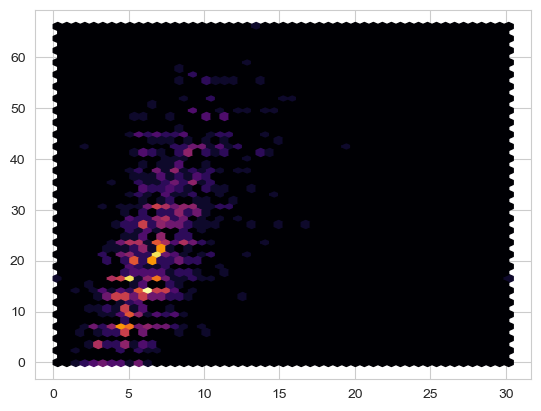

In [177]:
x = all_games_df.home_yardsPerPass
y = all_games_df.home_points
xlim = x.min(), x.max()
ylim = y.min(), y.max()

plt.hexbin(x, y, gridsize=50, cmap='inferno')